In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
from pyDOE import * # native python latin hypercube, no need for R

import seaborn as sns #pretty
sns.set()
sns.set_context('talk') #readable

#Our expensive physics simulation
import run_simple_energy_loss

import ptemcee
import subprocess
import pandas as pd

from joblib import Parallel, delayed

# Gaussian Process emulation
from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
from sklearn.gaussian_process import kernels #same
from sklearn.preprocessing import StandardScaler #useful for scaling data

In [2]:
#this function runs the physics simulator
simulation=run_simple_energy_loss.run_simulation

pT_range = (1, 10, 10) 
pT_bins = [3, 5, 7] # p_T bins we will use for the analysis
n_pT_bins = len(pT_bins)

#ranges/boundaries of prior
prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3),'scale_inel':(0.1,0.5), 'scale_el':(0.1,0.5)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel': 0.3, 'scale_el': 0.3}

prior_midpoint = np.array([.25, 0., 0., 0.3, 0.3]).reshape(1,-1)
prior_bds = ((0.05,0.5), (-3,3), (-3,3), (0.1,0.5), (0.1,0.5))

# We generate observables using the simulator at these parameters 
# and consider them as experimental pseudo-data
true_params = np.array([true_values['alpha_s'],  true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']]).reshape(1,-1)

In [3]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
obs_err = 0.02 # Amplitude of noise term
%time obs_Y = simulation(true_params, *pT_range)[:,pT_bins].flatten() # True model
obs_dY = obs_err * np.random.randn(n_pT_bins) # Add some random noise
obs_Y += obs_dY

running simulator with parameters : [ 0.2 -1.   1.   0.3  0.3]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


CPU times: user 25.2 s, sys: 106 ms, total: 25.3 s
Wall time: 25.5 s


In [4]:
print(true_params.shape)
print(obs_Y.shape)
print(obs_dY.shape)

(1, 5)
(3,)
(3,)


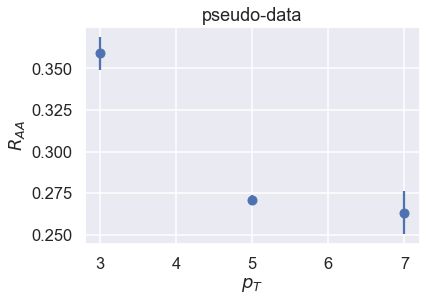

In [5]:
# plot pseudo-data for calibration
plt.errorbar(pT_bins, obs_Y, yerr=obs_dY, marker='o', ls='None')
plt.xlabel(r"$p_T$")
plt.ylabel(r"$R_{AA}$")
plt.title('pseudo-data')
plt.show()

Cell below defines some conditions we require of the gaussian process regressors

In [6]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

#Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e2)),
                      )
#This is a white noise kernel for finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-2, 1e1)
                        )
#kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

In [7]:
# a function to return a set of trained GP regressors of 
# inputs train_X onto outputs train_Y
def get_trained_gps(train_X, train_Y):
    nrestarts=10
    gps = []
    for i in range(train_Y.shape[1]):
        my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(train_X, train_Y[:,i])
        gps.append(my_gp)
    return gps

In [8]:
# a function to return the predictions of a set of 
# trained GP regressors at inputs X 
def trained_gps_predict(gps, X):
    Y = []
    dY = [] 
    for gp in gps:
        y, dy = gp.predict(X, return_std=True, return_cov=False)
        Y.append(y)
        dY.append(dy)
    return np.array(Y), np.array(dY)

In [9]:
# Define the log of likelihood function, which includes 
# the expt. pseudo-data. This will be used in the objective fct.
def log_likelihood(theta, obs_Y, obs_dY, gps):
    n_dim = obs_Y.shape[0]
  
    # Model parameters
    theta = np.array(theta).reshape((1, 5))
    
    # Model predictions given parameters
    model_Y, model_dY = trained_gps_predict(gps, theta)
    
    #total covaiance assuming diagonal exp. and theor. covariance matrices
    sigma = model_dY**2. + obs_dY**2.
    #discrepancy
    delta_Y = model_Y - obs_Y
    
    ll = -0.5*np.sum(delta_Y**2./sigma) -0.5*np.log( (2.*np.pi)**n_dim * np.prod(sigma) )
    return ll

def neg_log_likelihood(theta, obs_Y, obs_dY, gps):
    return -1.*log_likelihood(theta, obs_Y, obs_dY, gps)

In [10]:
#Root solver to maximize the objective fct. 
def find_max_likelihood(obs_Y, obs_dY, gps):
    x0 = prior_midpoint #pick a initial guess inside prior bounds 
    res = minimize(neg_log_likelihood, x0, 
                   args=(obs_Y, obs_dY, gps), bounds=prior_bds)
    if (res.success != True):
        print('minimization failed : ')
        print(res)
    return res.x

In [11]:
#the active learning algorithm
def active_learn(n_iters, train_X, train_Y):    
    
    #begin the sequential learning algo
    print('Starting active learning stage for '+str(n_iters)+ ' iterations')
    for iter in range(n_iters):
        print('############')
        print('Seq. design iter ' + str(iter))
        
        #train the GPs on existing data
        print('training gps')
        gps = get_trained_gps(train_X, train_Y )
        
        #search for new training point, which optimizes objective fct.
        print('optimizing likelihood')
        theta = find_max_likelihood(obs_Y, obs_dY, gps).reshape(1, 5)
        
        #get the updated model prediction
        model_Y = simulation(theta, *pT_range)[:,pT_bins]
        model_dY = 0. #temporary
        #append data to gp training set
        train_X = np.append(train_X, theta, axis=0)
        train_Y = np.append(train_Y, model_Y, axis=0)
        
    return train_X, train_Y, gps

### Before the active learning, first build a coarse initial training set using a sparse LHS design

In [12]:
n_pts_per_dim = 5
n_dim = 5
n_pts = n_dim * n_pts_per_dim

#make the latin hypercube of prior parameters
criterion='maximin'
hypcub = lhs(n_dim, samples=n_pts, criterion=criterion, iterations=9)
#rescale the axes of the cube

for i in range(n_dim):
    p_min, p_max = prior_bds[i]
    delta_p = p_max - p_min

    #rescaling and shifting 
    hypcub[:, i] = hypcub[:, i] * delta_p + p_min

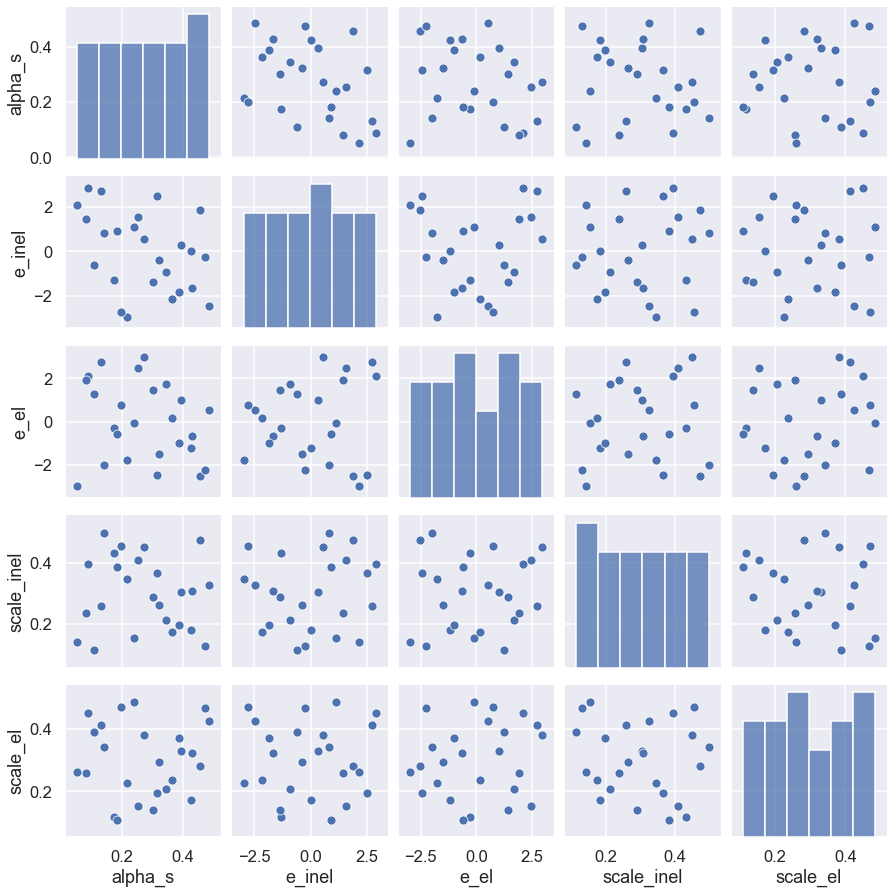

In [13]:
hypcub_df = pd.DataFrame(hypcub, columns = ['alpha_s','e_inel','e_el', 'scale_inel', 'scale_el'])
sns.pairplot(hypcub_df)
plt.tight_layout(True)
plt.show()

In [14]:
#if you haven't yet generated the LHS training set (cell below)
#turn this on
generate_new_LHS_train = False

In [15]:
if generate_new_LHS_train:
    #run the model on the LHS to build an initial sparse design
    train_X = hypcub
    train_Y = simulation(train_X, *pT_range)[:,pT_bins]

    #save to disk for reuse:
    with open('LHS_X.npy', 'wb') as f:
        np.save(f, train_X)
    with open('LHS_Y.npy', 'wb') as f:
        np.save(f, train_Y)

### Now we start the active learning algo.

In [16]:
with open('LHS_X.npy', 'rb') as f:
    train_X = np.load(f)
with open('LHS_Y.npy', 'rb') as f:
    train_Y = np.load(f)

In [17]:
n_iters=25
train_X, train_Y, gps = active_learn(n_iters=n_iters, train_X=train_X, train_Y=train_Y)

Starting active learning stage for 25 iterations
############
Seq. design iter 0
training gps
optimizing likelihood
running simulator with parameters : [ 1.96337190e-01 -8.07290486e-01  4.15364479e-04  3.62066877e-01
  2.87694182e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 1
training gps
optimizing likelihood
running simulator with parameters : [ 1.93074749e-01 -9.05785455e-01  6.77590675e-04  3.64162665e-01
  2.88731070e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 2
training gps
optimizing likelihood
running simulator with parameters : [ 1.89965396e-01 -9.93999717e-01 -3.40518356e-04  3.52185538e-01
  2.93428436e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 3
training gps
optimizing likelihood
running simulator with parameters : [ 1.88052012e-01 -1.04940770e+00 -6.17845865e-05  3.65948282e-01
  2.92589705e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 4
training gps
optimizing likelihood
running simulator with parameters : [ 1.85921601e-01 -1.10134069e+00 -5.50812542e-04  3.08105473e-01
  3.02466099e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 5
training gps
optimizing likelihood
running simulator with parameters : [ 1.84982850e-01 -1.15510566e+00 -9.40819032e-04  3.64556435e-01
  2.95528144e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 6
training gps
optimizing likelihood
running simulator with parameters : [ 0.18325522 -1.19066414 -0.00133226  0.36567471  0.29601977]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 7
training gps
optimizing likelihood
running simulator with parameters : [ 0.18172569 -1.22023214 -0.00133766  0.36697955  0.29770259]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 8
training gps
optimizing likelihood
running simulator with parameters : [ 1.80368924e-01 -1.24462066e+00 -9.17897506e-04  3.68203467e-01
  2.98623584e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 9
training gps
optimizing likelihood
running simulator with parameters : [ 0.17915515 -1.26493631 -0.00190994  0.36892451  0.29865949]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 10
training gps
optimizing likelihood
running simulator with parameters : [ 1.78084809e-01 -1.28182678e+00 -6.78326023e-04  3.10533678e-01
  3.02988339e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 11
training gps
optimizing likelihood
running simulator with parameters : [ 1.77753949e-01 -1.31258586e+00 -6.83899220e-04  3.11205973e-01
  3.02991677e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 12
training gps
optimizing likelihood
running simulator with parameters : [ 1.77444980e-01 -1.33946809e+00 -8.81670173e-04  3.66523521e-01
  3.01808571e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 13
training gps
optimizing likelihood
running simulator with parameters : [ 1.76591850e-01 -1.34832413e+00 -7.17387664e-04  3.11860187e-01
  3.03061414e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 14
training gps
optimizing likelihood
running simulator with parameters : [ 0.17635607 -1.37093698 -0.00164562  0.36642105  0.30336957]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 15
training gps
optimizing likelihood
running simulator with parameters : [ 1.75636215e-01 -1.37596618e+00 -6.08608642e-04  3.10336120e-01
  3.02737840e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 16
training gps
optimizing likelihood
running simulator with parameters : [ 1.75472165e-01 -1.39630430e+00 -6.41003556e-04  3.11018716e-01
  3.02869568e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 17
training gps
optimizing likelihood
running simulator with parameters : [ 0.17532293 -1.41390582 -0.00155837  0.36470038  0.30483108]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 18
training gps
optimizing likelihood
running simulator with parameters : [ 1.74739409e-01 -1.41496696e+00 -1.11553553e-03  3.65998904e-01
  3.05111379e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 19
training gps
optimizing likelihood
running simulator with parameters : [ 0.17421703 -1.41508018 -0.00190518  0.36584153  0.30574392]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 20
training gps
optimizing likelihood
running simulator with parameters : [ 0.17376368 -1.4145723  -0.00148473  0.3661206   0.30565161]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 21
training gps
optimizing likelihood
running simulator with parameters : [ 0.17336041 -1.41376002 -0.00163321  0.36627883  0.30619272]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 22
training gps
optimizing likelihood
running simulator with parameters : [ 1.73007422e-01 -1.41277427e+00 -7.04079177e-04  3.13716977e-01
  3.03419174e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 23
training gps
optimizing likelihood
running simulator with parameters : [ 0.17294963 -1.42669444 -0.00159166  0.36623623  0.30725963]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


############
Seq. design iter 24
training gps
optimizing likelihood
running simulator with parameters : [ 1.72638240e-01 -1.42491026e+00 -6.26745466e-04  3.12265149e-01
  3.03005711e-01]


/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/miniconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/derek/Work/JS-STAT-INTERNAL-current-projects/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


Let's visualize where the active learning procedure placed new design points

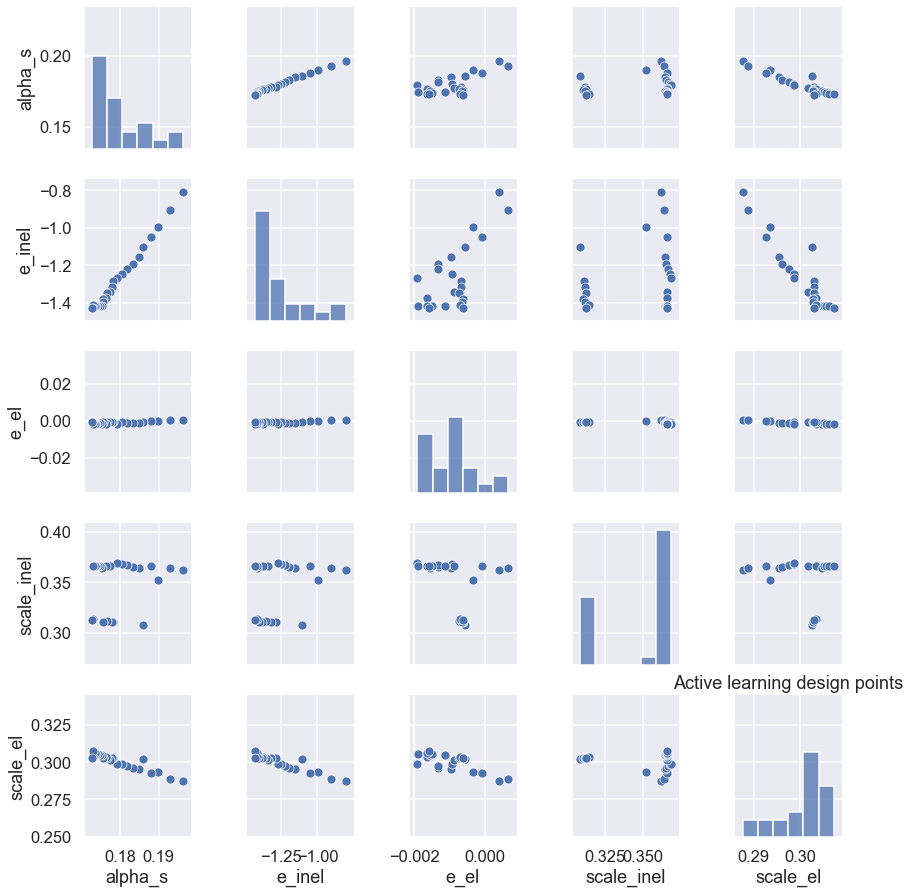

In [21]:
active_df = pd.DataFrame(train_X[25:], columns = ['alpha_s','e_inel','e_el', 'scale_inel', 'scale_el'])
sns.pairplot(active_df)
plt.tight_layout(True)
plt.show()